In [118]:
# All imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm import tqdm

In [112]:
# index to class mapping for all labels

age_map = ['1-2', '3-9', '10-20', '21-35', '36-60', '61-116']
gen_map = ['Male', 'Female']
eth_map = ["White", "Black", "Asian", "Indian", "Hispanic"]

In [2]:
# Dataset Class

class UTKDataset(Dataset):
    '''
        Inputs:
            dataFrame : Pandas dataFrame
            transform : The transform to apply to the dataset
    '''
    def __init__(self, dataFrame, transform=None):
        # read in the transforms
        self.transform = transform
        
        # Use the dataFrame to get the pixel values
        data_holder = dataFrame.pixels.apply(lambda x: np.array(x.split(" "),dtype=float))
        arr = np.stack(data_holder)
        arr = arr / 255.0
        arr = arr.astype('float32')
        arr = arr.reshape(arr.shape[0], 48, 48, 1) # reshape into 48x48x1
        self.data = arr
        
        # get the age, gender, and ethnicity label arrays
        self.age_label = np.array(dataFrame.bins[:])        
        self.gender_label = np.array(dataFrame.gender[:])
        self.eth_label = np.array(dataFrame.ethnicity[:])
    
    # override the length function
    def __len__(self):
        return len(self.data)
    
    # override the getitem function
    def __getitem__(self, index):
        # load the data at index and apply transform
        data = self.data[index]
        data = self.transform(data)
        
        # load the labels into a list and convert to tensors
        labels = torch.tensor((self.age_label[index], self.gender_label[index], self.eth_label[index]))
        
        # return data labels
        return data, labels

In [3]:
# MutiLabel CNN model Class

class MultiLabelCNN(nn.Module):
    def __init__(self, num_age, num_gen, num_eth):
        super(MultiLabelCNN, self).__init__()

        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #24
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #12
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #6
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1), #3
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )
        
        self.dnnModel = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
        )
        
        self.age_classifier = nn.Linear(32, num_age)
        self.gen_classifier = nn.Linear(32, num_gen)     
        self.eth_classifier = nn.Linear(32, num_eth)

    def forward(self, x):
        output = self.cnnModel(x)
        output = output.squeeze()
        output = self.dnnModel(output)
        
        age = self.age_classifier(output)
        gen = self.gen_classifier(output)
        eth = self.eth_classifier(output)

        return age, gen, eth

In [4]:
'''
  Function to test the trained model

  Inputs:
    - testloader : PyTorch DataLoader containing the test dataset
    - model : Trained NeuralNetwork
  
  Outputs:
    - Prints out test accuracy for age, gender and ethnicity
'''
def test(testloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu' 
  size = len(testloader.dataset)  
  model.eval() # put the model in evaluation mode for inference

  age_acc, gen_acc, eth_acc = 0, 0, 0

  with torch.no_grad(): # prevent gradient computation
      for X, y in testloader:
          X = X.to(device)
          age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
          pred = model(X)

          age_acc += (pred[0].argmax(1) == age).type(torch.float).sum().item()
          gen_acc += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
          eth_acc += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

  age_acc /= size
  gen_acc /= size
  eth_acc /= size

  print(f"Age Accuracy : {age_acc*100}%,     Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n")

In [148]:
'''
  Function to make the confusion matrices and classification reports out of the final model

  Inputs:
    - testloader : PyTorch DataLoader containing the test dataset
    - model : Trained NeuralNetwork
  
  Outputs:
    - Returns confusion matrices and classification reports for age, gender and ethnicity
'''

def metrics(testloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu' 
  model.eval() # put the model in evaluation mode so we aren't storing anything in the graph

  age_pred_all, gen_pred_all, eth_pred_all = torch.tensor([]).to(device), torch.tensor([]).to(device), torch.tensor([]).to(device)
  age_act_all, gen_act_all, eth_act_all = torch.tensor([]).to(device), torch.tensor([]).to(device), torch.tensor([]).to(device)

  with torch.no_grad():
      for images, labels in testloader:
          images = images.to(device)
          labels = labels.to(device)
          preds = model(images)
          age_pred, gen_pred, eth_pred = preds[0].argmax(1), preds[1].argmax(1), preds[2].argmax(1)
          age_pred_all, gen_pred_all, eth_pred_all = torch.concat((age_pred_all, age_pred), 0), torch.concat((gen_pred_all, gen_pred), 0), torch.concat((eth_pred_all, eth_pred), 0)
          age_act_all, gen_act_all, eth_act_all = torch.concat((age_act_all, labels[:, 0]), 0), torch.concat((gen_act_all, labels[:, 1]), 0), torch.concat((eth_act_all, labels[:, 2]), 0)
  
  # Generating a confusion matrix and classification report based on above predictions.

  cf_mat_age = confusion_matrix(age_act_all.tolist(), age_pred_all.tolist(), normalize='true')
  cf_mat_gen = confusion_matrix(gen_act_all.tolist(), gen_pred_all.tolist(), normalize='true')
  cf_mat_eth = confusion_matrix(eth_act_all.tolist(), eth_pred_all.tolist(), normalize='true')

  cl_rep_age = classification_report(age_act_all.tolist(), age_pred_all.tolist(), target_names=age_map)
  cl_rep_gen = classification_report(gen_act_all.tolist(), gen_pred_all.tolist(), target_names=gen_map)
  cl_rep_eth = classification_report(eth_act_all.tolist(), eth_pred_all.tolist(), target_names=eth_map)

  return cf_mat_age, cf_mat_gen, cf_mat_eth, cl_rep_age, cl_rep_gen, cl_rep_eth

In [6]:
# Read in the dataframe
dataFrame = pd.read_csv('../Data/age_gender.csv')

# Construct age bins
age_bins = [0,2,9,20,35,60,120]
age_labels = [0, 1, 2, 3, 4, 5]
dataFrame['bins'] = pd.cut(dataFrame.age, bins=age_bins, labels=age_labels)

# Split into training and testing
train_dataFrame, test_dataFrame = train_test_split(dataFrame, test_size=0.2)

# get the number of unique classes for each group
class_nums = {'age_num':len(dataFrame['bins'].unique()), 'eth_num':len(dataFrame['ethnicity'].unique()),
              'gen_num':len(dataFrame['gender'].unique())}

# Define train and test transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

# Construct the custom pytorch datasets
train_set = UTKDataset(train_dataFrame, transform=train_transform)
test_set = UTKDataset(test_dataFrame, transform=test_transform)

# Load the datasets into dataloaders
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
testloader = DataLoader(test_set, batch_size=128, shuffle=False)

# Sanity Check
for X, y in trainloader:
    print(f'Shape of training X: {X.shape}')
    print(f'Shape of y: {y.shape}')
    break

Shape of training X: torch.Size([64, 1, 48, 48])
Shape of y: torch.Size([64, 3])


In [7]:
# Configure the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

# Define the list of hyperparameters
hyperparameters = {'learning_rate':0.001, 'epochs':20}

# Initialize the MultiLabelCNN model and put on device
model = MultiLabelCNN(class_nums['age_num'], class_nums['gen_num'], class_nums['eth_num'])
model.to(device)
summary(model, (64, 1, 48, 48)) # summary of the model using torchinfo

cuda


Layer (type:depth-idx)                   Output Shape              Param #
MultiLabelCNN                            [64, 6]                   --
├─Sequential: 1-1                        [64, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 32, 48, 48]          320
│    └─MaxPool2d: 2-2                    [64, 32, 24, 24]          --
│    └─LeakyReLU: 2-3                    [64, 32, 24, 24]          --
│    └─Conv2d: 2-4                       [64, 64, 24, 24]          18,496
│    └─MaxPool2d: 2-5                    [64, 64, 12, 12]          --
│    └─LeakyReLU: 2-6                    [64, 64, 12, 12]          --
│    └─Conv2d: 2-7                       [64, 128, 12, 12]         73,856
│    └─MaxPool2d: 2-8                    [64, 128, 6, 6]           --
│    └─LeakyReLU: 2-9                    [64, 128, 6, 6]           --
│    └─Conv2d: 2-10                      [64, 256, 6, 6]           295,168
│    └─MaxPool2d: 2-11                   [64, 256, 3, 3]           --
│

In [8]:
'''
  Functions to load and save a PyTorch model
'''
def save_checkpoint(state, epoch):
  print("Saving Checkpoint")
  filename = "../checkpoints/MultiLabelCNN_epoch"+str(epoch)+".pth.tar"
  torch.save(state,filename)

def load_checkpoint(checkpoint):
  print("Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  opt.load_state_dict(checkpoint['optimizer'])


In [9]:
'''
  Train the model
''' 
# Load hyperparameters
learning_rate = hyperparameters['learning_rate']
num_epoch = hyperparameters['epochs']

# Define loss functions
age_loss = nn.CrossEntropyLoss()
gen_loss = nn.CrossEntropyLoss() 
eth_loss = nn.CrossEntropyLoss()

# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epoch):
  # Construct tqdm loop to keep track of training
  loop = tqdm(enumerate(trainloader), total=len(trainloader), position=0, leave=True)
  age_correct, gen_correct, eth_correct, total = 0,0,0,0

  # save the model every 5 epochs
  if epoch % 5 == 0:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : opt.state_dict(), 
                  'age_loss' : age_loss, 'gen_loss' : gen_loss, 'eth_loss' : eth_loss}
    save_checkpoint(checkpoint, epoch)

  # Loop through dataLoader
  for _, (X,y) in loop:
    # Unpack y to get true age, eth, and gen values
    # Have to do some special changes to age label to make it compatible with NN output and Loss function
    #age, gen, eth = y[:,0].resize_(len(y[:,0]),1).float().to(device), y[:,1].to(device), y[:,2].to(device)
    age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
    X = X.to(device)
    pred = model(X)          # Forward pass
    loss = age_loss(pred[0],age) + gen_loss(pred[1],gen) + eth_loss(pred[2],eth)   # Loss calculation

    # Backpropagation
    opt.zero_grad()          # Zero the gradient
    loss.backward()          # Calculate updates

    # Gradient Descent
    opt.step()               # Apply updates

    # Update num correct and total
    age_correct += (pred[0].argmax(1) == age).type(torch.float).sum().item()
    gen_correct += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
    eth_correct += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

    total += len(y)

    # Update progress bar
    loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
    loop.set_postfix(loss = loss.item())

  # Update epoch accuracy
  gen_acc, eth_acc, age_acc = gen_correct/total, eth_correct/total, age_correct/total

  # print out accuracy and loss for epoch
  print(f'Epoch : {epoch+1}/{num_epoch},    Age Accuracy : {age_acc*100},    Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n')

Epoch [1/20]:   0%|          | 1/297 [00:00<00:42,  6.94it/s, loss=4.1] 

Saving Checkpoint


Epoch [1/20]: 100%|██████████| 297/297 [00:05<00:00, 52.19it/s, loss=3.34]


Epoch : 1/20,    Age Accuracy : 45.48091120016874,    Gender Accuracy : 63.85783589959924,    Ethnicity Accuracy : 47.22632356043029



Epoch [2/20]: 100%|██████████| 297/297 [00:05<00:00, 53.80it/s, loss=2.18]


Epoch : 2/20,    Age Accuracy : 56.10630668635309,    Gender Accuracy : 78.46973212402447,    Ethnicity Accuracy : 57.85171904661463



Epoch [3/20]: 100%|██████████| 297/297 [00:05<00:00, 53.85it/s, loss=1.66]


Epoch : 3/20,    Age Accuracy : 61.368909512761014,    Gender Accuracy : 83.01518666947901,    Ethnicity Accuracy : 67.54376713773466



Epoch [4/20]: 100%|██████████| 297/297 [00:05<00:00, 52.94it/s, loss=2.03]


Epoch : 4/20,    Age Accuracy : 64.59080362792659,    Gender Accuracy : 85.72558531955283,    Ethnicity Accuracy : 72.0523096393166



Epoch [5/20]: 100%|██████████| 297/297 [00:05<00:00, 51.94it/s, loss=1.25]


Epoch : 5/20,    Age Accuracy : 66.63151233916895,    Gender Accuracy : 87.23897911832947,    Ethnicity Accuracy : 74.62560641214934



Epoch [6/20]:   2%|▏         | 6/297 [00:00<00:05, 51.28it/s, loss=1.51]

Saving Checkpoint


Epoch [6/20]: 100%|██████████| 297/297 [00:05<00:00, 54.37it/s, loss=1.57]


Epoch : 6/20,    Age Accuracy : 68.36110525205653,    Gender Accuracy : 88.09850242564859,    Ethnicity Accuracy : 76.27610208816705



Epoch [7/20]: 100%|██████████| 297/297 [00:05<00:00, 52.92it/s, loss=1.14]


Epoch : 7/20,    Age Accuracy : 69.76376291921535,    Gender Accuracy : 88.7154608732335,    Ethnicity Accuracy : 78.14279687829571



Epoch [8/20]: 100%|██████████| 297/297 [00:05<00:00, 56.69it/s, loss=2.01]


Epoch : 8/20,    Age Accuracy : 71.21915207762075,    Gender Accuracy : 89.66990086479646,    Ethnicity Accuracy : 78.81775996625184



Epoch [9/20]: 100%|██████████| 297/297 [00:05<00:00, 54.50it/s, loss=1.12] 


Epoch : 9/20,    Age Accuracy : 72.3106939464248,    Gender Accuracy : 90.24994726850876,    Ethnicity Accuracy : 80.47352879139422



Epoch [10/20]: 100%|██████████| 297/297 [00:05<00:00, 53.51it/s, loss=1.41] 


Epoch : 10/20,    Age Accuracy : 73.46024045560009,    Gender Accuracy : 90.80890107572243,    Ethnicity Accuracy : 81.59670955494622



Epoch [11/20]:   2%|▏         | 5/297 [00:00<00:05, 49.02it/s, loss=1.44]

Saving Checkpoint


Epoch [11/20]: 100%|██████████| 297/297 [00:05<00:00, 52.46it/s, loss=1.2]  


Epoch : 11/20,    Age Accuracy : 74.93672221050412,    Gender Accuracy : 91.37840118118541,    Ethnicity Accuracy : 82.67770512550095



Epoch [12/20]: 100%|██████████| 297/297 [00:05<00:00, 53.64it/s, loss=1.27] 


Epoch : 12/20,    Age Accuracy : 76.492301202278,    Gender Accuracy : 91.92153554102511,    Ethnicity Accuracy : 83.9907192575406



Epoch [13/20]: 100%|██████████| 297/297 [00:05<00:00, 54.10it/s, loss=1.06] 


Epoch : 13/20,    Age Accuracy : 77.77894958869437,    Gender Accuracy : 92.56485973423328,    Ethnicity Accuracy : 84.80805737186247



Epoch [14/20]: 100%|██████████| 297/297 [00:05<00:00, 52.99it/s, loss=1.16] 


Epoch : 14/20,    Age Accuracy : 78.92322294874499,    Gender Accuracy : 93.13963298882092,    Ethnicity Accuracy : 85.61484918793504



Epoch [15/20]: 100%|██████████| 297/297 [00:05<00:00, 53.61it/s, loss=1.1]  


Epoch : 15/20,    Age Accuracy : 80.10968150179288,    Gender Accuracy : 93.76186458553047,    Ethnicity Accuracy : 86.50073824087745



Epoch [16/20]:   2%|▏         | 5/297 [00:00<00:06, 47.16it/s, loss=0.944]

Saving Checkpoint


Epoch [16/20]: 100%|██████████| 297/297 [00:05<00:00, 55.00it/s, loss=1.33] 


Epoch : 16/20,    Age Accuracy : 80.74245939675174,    Gender Accuracy : 93.97279055051678,    Ethnicity Accuracy : 87.24952541657878



Epoch [17/20]: 100%|██████████| 297/297 [00:05<00:00, 54.52it/s, loss=0.762]


Epoch : 17/20,    Age Accuracy : 81.88673275680236,    Gender Accuracy : 94.61084159460029,    Ethnicity Accuracy : 88.28833579413626



Epoch [18/20]: 100%|██████████| 297/297 [00:05<00:00, 56.35it/s, loss=1.04] 


Epoch : 18/20,    Age Accuracy : 83.70596920480912,    Gender Accuracy : 94.67411938409617,    Ethnicity Accuracy : 88.69436827673486



Epoch [19/20]: 100%|██████████| 297/297 [00:05<00:00, 53.20it/s, loss=1.34] 


Epoch : 19/20,    Age Accuracy : 84.93461295085424,    Gender Accuracy : 95.08542501581945,    Ethnicity Accuracy : 89.98101666315124



Epoch [20/20]: 100%|██████████| 297/297 [00:05<00:00, 52.44it/s, loss=0.574]

Epoch : 20/20,    Age Accuracy : 85.56211769668846,    Gender Accuracy : 95.5969204809112,    Ethnicity Accuracy : 90.77726218097449



In [10]:
checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : opt.state_dict(), 
                'age_loss' : age_loss, 'gen_loss' : gen_loss, 'eth_loss' : eth_loss}

save_checkpoint(checkpoint, 'final')

test(testloader, model)

Saving Checkpoint
Age Accuracy : 70.21725374393588%,     Gender Accuracy : 88.54672010124446,    Ethnicity Accuracy : 77.62075511495465



In [149]:
# Generating confusion matrices and classification reports from the trained model above

cf_mat_age, cf_mat_gen, cf_mat_eth, cl_rep_age, cl_rep_gen, cl_rep_eth = metrics(testloader, model)

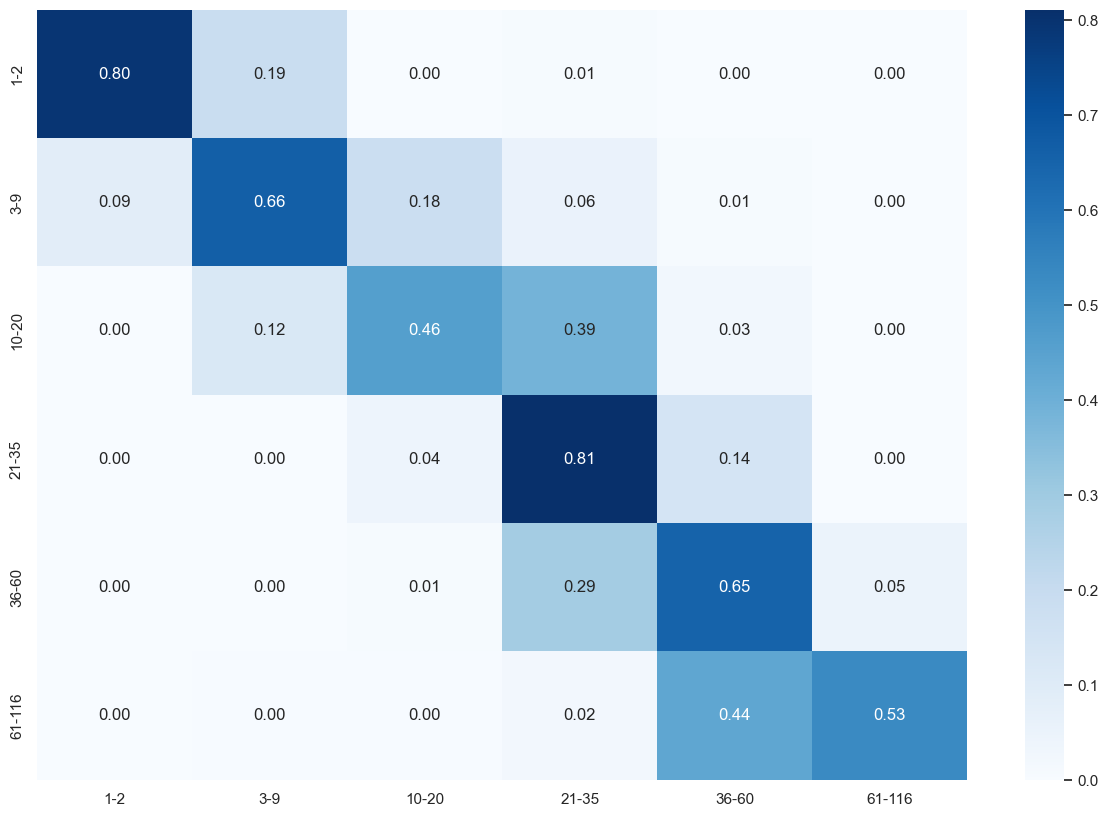

In [157]:
# Plotting the confusion matrix for age

df_cm = pd.DataFrame(cf_mat_age, age_map, age_map)
plt.figure(figsize=(15,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 12}, fmt = '.2f') # font size and format
plt.savefig('../outputs/confusion_matrix_age.png')
plt.show()

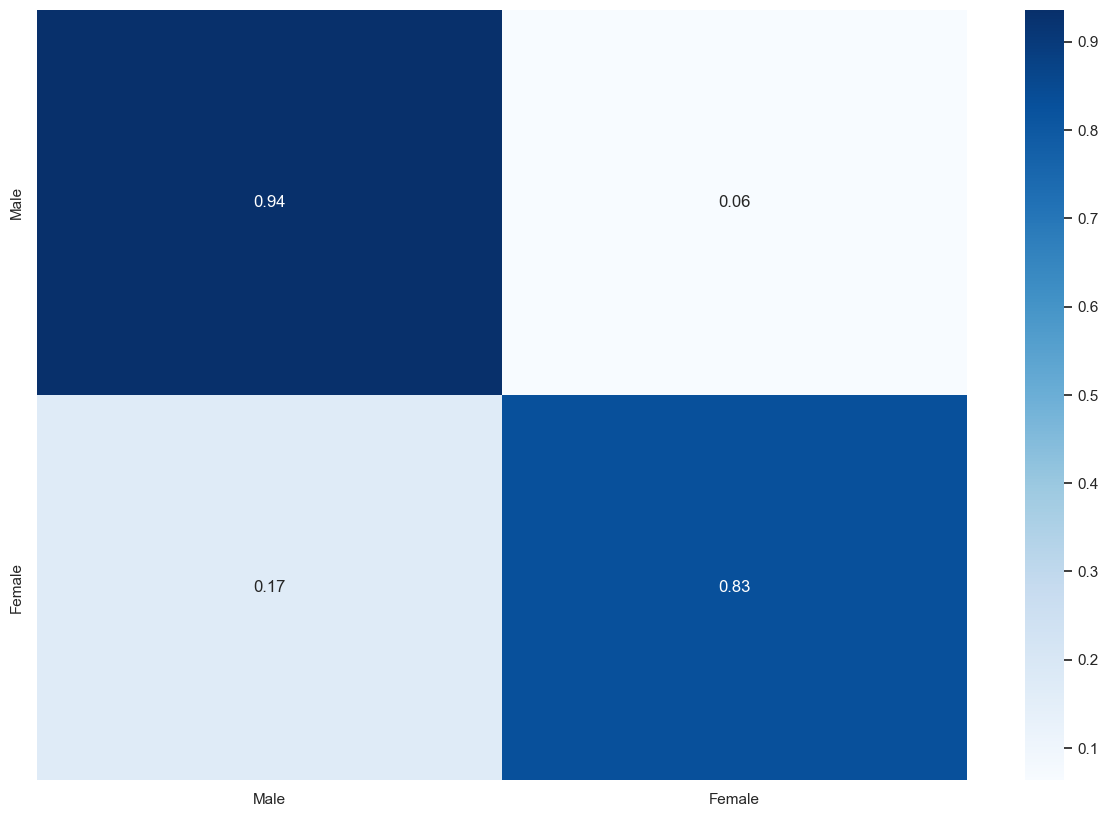

In [155]:
# Plotting the confusion matrix for gender

df_cm = pd.DataFrame(cf_mat_gen, gen_map, gen_map)
plt.figure(figsize=(15,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 12}, fmt = '.2f') # font size and format
plt.savefig('../outputs/confusion_matrix_gender.png')
plt.show()

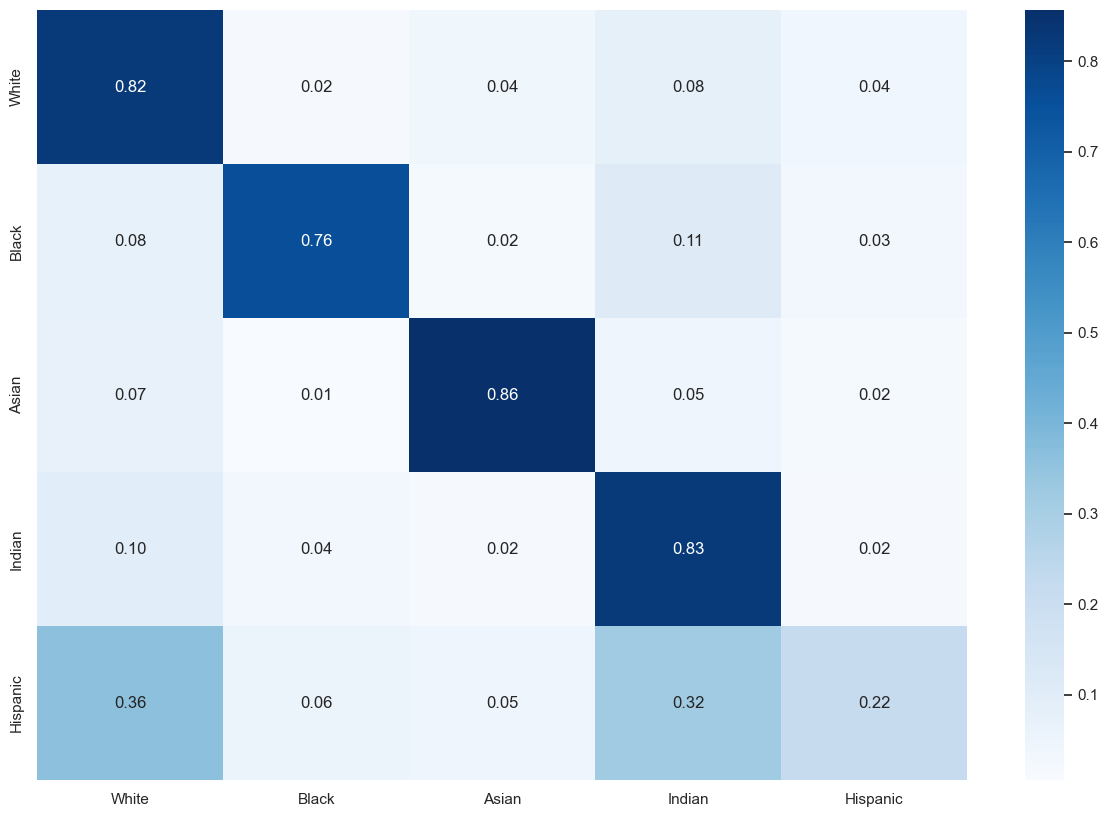

In [156]:
# Plotting the confusion matrix for ethnicity

df_cm = pd.DataFrame(cf_mat_eth, eth_map, eth_map)
plt.figure(figsize=(15,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 12}, fmt = '.2f') # font size and format
plt.savefig('../outputs/confusion_matrix_ethnicity.png')
plt.show()

In [169]:
# Printing the classification report for age

with open('../outputs/classification_report_age.txt', 'w') as f:
    print(cl_rep_age, file=f)

print(cl_rep_age)

              precision    recall  f1-score   support

         1-2       0.90      0.80      0.84       322
         3-9       0.65      0.66      0.66       317
       10-20       0.53      0.46      0.49       373
       21-35       0.75      0.81      0.78      1984
       36-60       0.62      0.65      0.64      1275
      61-116       0.80      0.53      0.64       470

    accuracy                           0.70      4741
   macro avg       0.71      0.65      0.67      4741
weighted avg       0.70      0.70      0.70      4741



In [170]:
# Printing the classification report for gender

with open('../outputs/classification_report_gender.txt', 'w') as f:
    print(cl_rep_gen, file=f)

print(cl_rep_gen)

              precision    recall  f1-score   support

        Male       0.86      0.94      0.90      2491
      Female       0.92      0.83      0.87      2250

    accuracy                           0.89      4741
   macro avg       0.89      0.88      0.88      4741
weighted avg       0.89      0.89      0.88      4741



In [ ]:
# Printing the classification report for ethnicity

with open('../outputs/classification_report_ethnicity.txt', 'w') as f:
    print(cl_rep_eth, file=f)

print(cl_rep_eth)

              precision    recall  f1-score   support

       White       0.84      0.82      0.83      2023
       Black       0.89      0.76      0.82       939
       Asian       0.82      0.86      0.84       663
      Indian       0.63      0.83      0.71       813
    Hispanic       0.32      0.22      0.26       303

    accuracy                           0.78      4741
   macro avg       0.70      0.70      0.69      4741
weighted avg       0.78      0.78      0.77      4741

